In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel, model
import geopandas as gpd
if manual:
    %matplotlib inline

SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'
input_folder = training_folder + r'inputs/'
plot_path = training_folder + 'outputs/plot/'

In [4]:
sm = stepmodel.read_zip(training_folder + 'model/base/base.zip')

read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 72.78it/s]


In [5]:
sm.nodes.index = sm.nodes['stop_id']

# add road

In [6]:
road_links = gpd.read_file(input_folder+'road/road_links.geojson', driver='GeoJSON')
road_nodes = gpd.read_file(input_folder+'road/road_nodes.geojson', driver='GeoJSON')
road_nodes.set_index('index', inplace=True)
sm.road_links = road_links
sm.road_nodes = road_nodes

In [7]:
road_links.head()

,index,a,b,length,geometry
0,2,166297606,25240349,311.138,"LINESTRING (2.36014 48.81642, 2.35595 48.81673)"
1,3,166297606,249076496,42.131,"LINESTRING (2.36014 48.81642, 2.36015 48.81605)"
2,4,271450120,27339859,96.693,"LINESTRING (2.27789 48.87569, 2.27904 48.87587)"
3,5,271450120,442306,103.415,"LINESTRING (2.27789 48.87569, 2.27852 48.87494)"
4,8,166297610,166300778,64.116,"LINESTRING (2.36065 48.81587, 2.36050 48.81641)"


# road integrity

In [8]:
sm.integrity_fix_collision()

can not add prefixes on table:  footpaths


## road_fix

In [9]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 6254it [00:01, 3267.45it/s]
reversed: 6254it [00:02, 2723.87it/s]
5927it [00:01, 2970.92it/s]


## road_test

In [10]:
sm.integrity_test_dead_ends()

5927it [00:00, 11398.06it/s]


In [11]:
sm.integrity_fix_nodeset_consistency()

In [12]:
sm.integrity_test_isolated_roads()

# Transport Integrity

## transport_fix

In [13]:
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()

dropped circular lines: ['100100129:129_1', '100100388:388_1', '100100150:150_1', '100100194:194_1', '100100290:290_1', '100100323:323_1', '100100152:152_1', '100100249:249_1', '100100105:105_1']


## transport_test

In [14]:
sm.integrity_fix_nodeset_consistency()

In [15]:
sm.integrity_test_circular_lines()
sm.integrity_test_collision()
sm.integrity_test_nodeset_consistency()
sm.integrity_test_sequences()

In [16]:
sm.integrity_test_all(errors='raise')

1250it [00:00, 12499.45it/s]

passed: integrity_test_circular_lines
passed: integrity_test_collision


5927it [00:00, 13379.17it/s]


passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


5927it [00:01, 3369.56it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


In [17]:
sm = sm.change_epsg(epsg=3857, coordinates_unit='meter')

Reprojecting model from epsg 4326 to epsg 3857: 100%|██████████████████████████████████| 39/39 [00:05<00:00,  6.79it/s]

could not change epsg for the following attributes: 
['jsons']


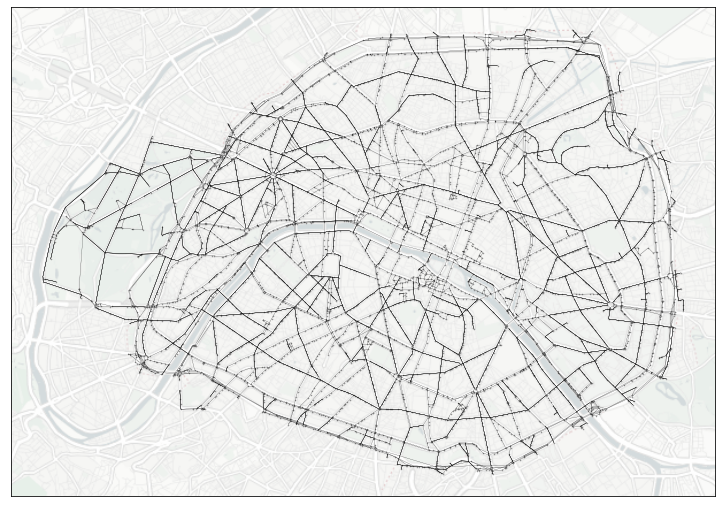

In [18]:
if manual:
    sm.plot(
        'road_nodes', color='grey', markersize=0.2,
        ax=sm.plot(
            'road_links', figsize=[16, 9], 
            basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png', linewidth=0.2, color='black'
        ),    
    )

# to_zip

In [19]:
sm.to_zip(training_folder + 'model/base/networks.zip')   

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 39/39 [00:07<00:00,  5.40it/s]


could not save attribute: missing_road_nodes
could not save attribute: missing_nodes
could not save attribute: orphan_nodes


# END